In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("dataset_SCL.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# DESAFIO

# 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [2]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


En si hay pocos datos, solo hay variables relevantes como las fechas y ciudad; las demas variables se desglosan a partir de estas variables relevantes. El reto principal es construir el target y tranformar las demas variables.

# 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

### temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.


In [3]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])

df.loc[ (df['Fecha-I'] > "2016-12-15 00:00:00") & (df['Fecha-I'] < "2017-03-03 00:00:00"), 'temporada_alta'] = 1
df.loc[ (df['Fecha-I'] > "2017-07-15 00:00:00") & (df['Fecha-I'] < "2017-07-31 00:00:00"), 'temporada_alta'] = 1
df.loc[ (df['Fecha-I'] > "2017-09-11 00:00:00") & (df['Fecha-I'] < "2017-09-30 00:00:00"), 'temporada_alta'] = 1 

df["temporada_alta"]=df["temporada_alta"].fillna(0).astype(int)

#### dif_min : diferencia en minutos entre Fecha-O y Fecha-I .

In [4]:
def date_diff(date1, date2):
    return (date1 -  date2)
df["d"] = date_diff(df["Fecha-O"] , df["Fecha-I"])

df["dif_min"]=df["d"] / np.timedelta64(1, 'm')

del df["d"] 

#### atraso_15 : 1 si dif_min > 15, 0 si no. 

In [5]:
df.loc[df['dif_min'] > 15, 'atraso_15'] = 1 
df.loc[df['dif_min'] <= 15, 'atraso_15'] = 0 

#### periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I . 

In [6]:
df.loc[ (df['Fecha-I'].dt.hour > 4) & (df['Fecha-I'].dt.hour < 12), 'periodo_dia'] = 'mañana' 
df.loc[ (df['Fecha-I'].dt.hour > 11) & (df['Fecha-I'].dt.hour <19), 'periodo_dia'] = 'tarde' 
df["periodo_dia"]=df["periodo_dia"].fillna("noche")

#### Exportamos

In [7]:
df.to_csv("synthetic_features.csv", index=False)

In [8]:
del df["temporada_alta"]
del df["dif_min"]
del df["atraso_15"]
del df["periodo_dia"]

# 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

In [38]:
df.columns

Index(['Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O',
       'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'target'],
      dtype='object')

In [44]:
df.groupby(["DIANOM","TIPOVUELO"])["target"].count()

DIANOM  TIPOVUELO
0       0            4547
        1            5249
1       0            4440
        1            5811
2       0            4492
        1            5639
3       0            4333
        1            5329
4       0            4419
        1            5303
5       0            4491
        1            3861
6       0            4518
        1            5774
Name: target, dtype: int64

In [45]:
df.corr()

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,target
Vlo-I,1.000000,NaN,-0.109460,0.024909,0.996093,NaN,-0.114188,-0.012006,0.000027,-0.014481,0.004656,0.009984,-0.470857,0.026378
Ori-I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-I,-0.109460,NaN,1.000000,0.320684,-0.107838,NaN,0.999695,0.408554,0.000526,-0.007479,-0.009979,0.001053,0.358069,0.005333
Emp-I,0.024909,NaN,0.320684,1.000000,0.031407,NaN,0.323207,0.920175,0.002544,0.002030,-0.001038,0.001626,0.292652,-0.003453
Vlo-O,0.996093,NaN,-0.107838,0.031407,1.000000,NaN,-0.112534,-0.007808,-0.000142,-0.010110,0.004985,0.009687,-0.475621,0.026266
Ori-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-O,-0.114188,NaN,0.999695,0.323207,-0.112534,NaN,1.000000,0.411981,0.000500,-0.007298,-0.009996,0.000955,0.363522,0.005221
Emp-O,-0.012006,NaN,0.408554,0.920175,-0.007808,NaN,0.411981,1.000000,0.001036,-0.013458,-0.001722,-0.003393,0.437365,-0.024349
DIA,0.000027,NaN,0.000526,0.002544,-0.000142,NaN,0.000500,0.001036,1.000000,0.014318,-0.009073,-0.007998,0.001277,-0.002515
MES,-0.014481,NaN,-0.007479,0.002030,-0.010110,NaN,-0.007298,-0.013458,0.014318,1.000000,-0.008642,0.009252,0.011564,0.031016


Esperaría que las variables DIANOM (nombre del dia), DIA y MES sean las variables que tengan una mayor influencia para predicción

# 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

# Cargamos la libreria

In [10]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

# Lectura de datos

In [11]:
df = pd.read_csv("dataset_SCL.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


#### Convertimos estas variables a formato fecha

In [13]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

# CREAMOS EL TARGET 

#### -> Diferencia de mas de una hora = retraso

In [14]:
def date_diff(date1, date2):
    return (date1 -  date2)
df["d"] = date_diff(df["Fecha-O"] , df["Fecha-I"])

df["dif"]=df["d"] / np.timedelta64(1, 's')

df.loc[df['dif'] > 3600, 'target'] = 1 
df.loc[df['dif'] <= 3600, 'target'] = 0 

#### Graficamos un histograma para ver como se comporta la variable "dif"

(array([33611., 25509.,  5143.,  1631.,   881.,   515.,   351.,   254.,
          168.,   143.]),
 array([-840.,  210., 1260., 2310., 3360., 4410., 5460., 6510., 7560.,
        8610., 9660.]),
 <BarContainer object of 10 artists>)

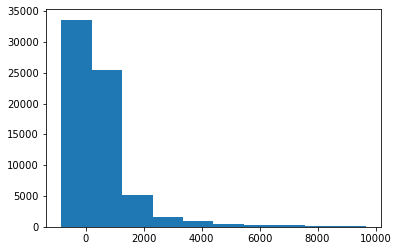

In [15]:
import matplotlib.pyplot as plt
plt.hist(df["dif"])

In [16]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,d,dif,target
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,0 days 00:03:00,180.0,0.0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,0 days 00:09:00,540.0,0.0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,0 days 00:09:00,540.0,0.0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,0 days 00:03:00,180.0,0.0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,-1 days +23:58:00,-120.0,0.0


In [17]:
df['Vlo-I']=df['Vlo-I'].astype(str)
df['Vlo-O']=df['Vlo-O'].astype(str)

In [18]:
label_encoder = preprocessing.LabelEncoder()

df['DIANOM']= label_encoder.fit_transform(df['DIANOM'])
df['Ori-I']= label_encoder.fit_transform(df['Ori-I'])
df['Des-I']= label_encoder.fit_transform(df['Des-I'])
df['Emp-I']= label_encoder.fit_transform(df['Emp-I'])
df['Ori-O']= label_encoder.fit_transform(df['Ori-O'])
df['Des-O']= label_encoder.fit_transform(df['Des-O'])
df['Emp-O']= label_encoder.fit_transform(df['Emp-O'])
df['AÑO']= label_encoder.fit_transform(df['AÑO'])
df['Vlo-I']= label_encoder.fit_transform(df['Vlo-I'])
df['Vlo-O']= label_encoder.fit_transform(df['Vlo-O'])
df['TIPOVUELO']= label_encoder.fit_transform(df['TIPOVUELO'])

In [19]:
df.dtypes

Fecha-I       datetime64[ns]
Vlo-I                  int32
Ori-I                  int32
Des-I                  int32
Emp-I                  int32
Fecha-O       datetime64[ns]
Vlo-O                  int32
Ori-O                  int32
Des-O                  int32
Emp-O                  int32
DIA                    int64
MES                    int64
AÑO                    int64
DIANOM                 int32
TIPOVUELO              int32
OPERA                 object
SIGLAORI              object
SIGLADES              object
d            timedelta64[ns]
dif                  float64
target               float64
dtype: object

#### PROCEDEMOS A ELIMINAR VARIABLES QUE NO APORTAN

In [20]:
del df["SIGLAORI"]
del df["SIGLADES"]
del df["OPERA"]
del df["Fecha-O"]
del df["Fecha-I"]
del df["d"] 

#### VEMOS LA CANTIDAD DE NULOS (NO HAY)

In [21]:
df.isnull().sum()

Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Vlo-O        0
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
dif          0
target       0
dtype: int64

#### REVISAMOS SI HAY VARIABLES CORRELACIONADA CON EL TARGET 

In [22]:
(df.corr())

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,dif,target
Vlo-I,1.000000,NaN,-0.109460,0.024909,0.996093,NaN,-0.114188,-0.012006,0.000027,-0.014481,0.004656,0.009984,-0.470857,0.068428,0.026378
Ori-I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-I,-0.109460,NaN,1.000000,0.320684,-0.107838,NaN,0.999695,0.408554,0.000526,-0.007479,-0.009979,0.001053,0.358069,0.027725,0.005333
Emp-I,0.024909,NaN,0.320684,1.000000,0.031407,NaN,0.323207,0.920175,0.002544,0.002030,-0.001038,0.001626,0.292652,0.028418,-0.003453
Vlo-O,0.996093,NaN,-0.107838,0.031407,1.000000,NaN,-0.112534,-0.007808,-0.000142,-0.010110,0.004985,0.009687,-0.475621,0.067838,0.026266
Ori-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-O,-0.114188,NaN,0.999695,0.323207,-0.112534,NaN,1.000000,0.411981,0.000500,-0.007298,-0.009996,0.000955,0.363522,0.028055,0.005221
Emp-O,-0.012006,NaN,0.408554,0.920175,-0.007808,NaN,0.411981,1.000000,0.001036,-0.013458,-0.001722,-0.003393,0.437365,0.002289,-0.024349
DIA,0.000027,NaN,0.000526,0.002544,-0.000142,NaN,0.000500,0.001036,1.000000,0.014318,-0.009073,-0.007998,0.001277,-0.006706,-0.002515
MES,-0.014481,NaN,-0.007479,0.002030,-0.010110,NaN,-0.007298,-0.013458,0.014318,1.000000,-0.008642,0.009252,0.011564,0.077280,0.031016


#### ELIMINAMOS LA VARIABLE CORRELACIONADA CON EL TARGET 

In [23]:
del df["dif"]

In [24]:
df.columns

Index(['Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O',
       'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'target'],
      dtype='object')

#### DEFINICIÓN DE DATASET PARA ENTRENAMIENTO

In [25]:
X = df[['Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O',
       'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO']]
y = df["target"]

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### PROBANDO LIGHTGBM 

In [27]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

gbm = lgb.LGBMClassifier(n_estimators=50, max_depth=8)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)])

# Make predictions on the testing set
y_pred = gbm.predict(X_test)

# Calculate the mean squared error
#mse = mean_squared_error(y_test, y_pred)
accuracy=accuracy_score(y_pred, y_test)
print("accuracy: %.2f" % accuracy)


[1]	valid_0's binary_logloss: 0.138866
[2]	valid_0's binary_logloss: 0.13684
[3]	valid_0's binary_logloss: 0.135482
[4]	valid_0's binary_logloss: 0.134285
[5]	valid_0's binary_logloss: 0.133299
[6]	valid_0's binary_logloss: 0.132603
[7]	valid_0's binary_logloss: 0.132011
[8]	valid_0's binary_logloss: 0.13154
[9]	valid_0's binary_logloss: 0.130958
[10]	valid_0's binary_logloss: 0.130628
[11]	valid_0's binary_logloss: 0.130259
[12]	valid_0's binary_logloss: 0.130023
[13]	valid_0's binary_logloss: 0.129728
[14]	valid_0's binary_logloss: 0.129496
[15]	valid_0's binary_logloss: 0.129308
[16]	valid_0's binary_logloss: 0.129138
[17]	valid_0's binary_logloss: 0.12919
[18]	valid_0's binary_logloss: 0.128873
[19]	valid_0's binary_logloss: 0.128709
[20]	valid_0's binary_logloss: 0.128383
[21]	valid_0's binary_logloss: 0.128344
[22]	valid_0's binary_logloss: 0.128242
[23]	valid_0's binary_logloss: 0.127958
[24]	valid_0's binary_logloss: 0.127925
[25]	valid_0's binary_logloss: 0.127959
[26]	valid_0

In [28]:
y_pred_train = gbm.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Training-set accuracy score: 0.9724
Confusion matrix

 [[13193     6]
 [  431    12]]

True Positives(TP) =  13193

True Negatives(TN) =  12

False Positives(FP) =  6

False Negatives(FN) =  431


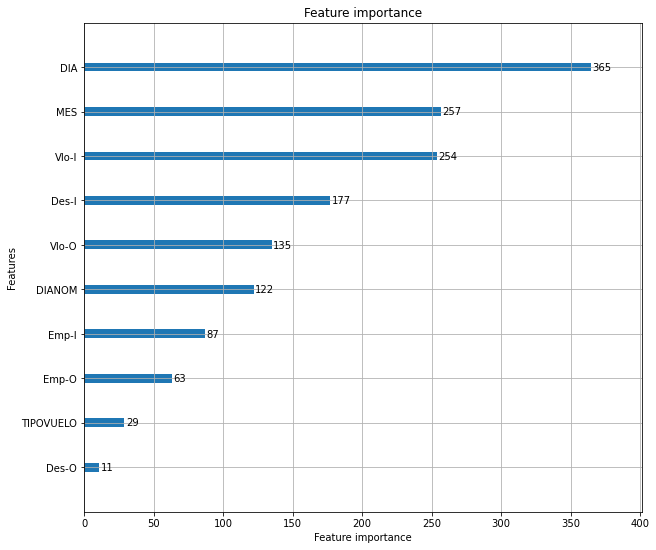

In [51]:
from lightgbm import LGBMClassifier, plot_importance 
plot_importance(gbm, figsize=(10, 9));

#### PROBANDO XGBOOST

In [29]:
from xgboost import XGBClassifier
import xgboost as xgb

model_xgb = xgb.XGBClassifier(n_estimators=50, max_depth=8)

model_xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)])

# Make predictions on the testing set
y_pred = model_xgb.predict(X_test)

# Calculate the mean squared error
#mse = mean_squared_error(y_test, y_pred)
accuracy=accuracy_score(y_pred, y_test)
print("accuracy: %.2f" % accuracy)

[03:19:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.46669
[1]	validation_0-logloss:0.34357
[2]	validation_0-logloss:0.26791
[3]	validation_0-logloss:0.21935
[4]	validation_0-logloss:0.18740
[5]	validation_0-logloss:0.16612


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-logloss:0.15215
[7]	validation_0-logloss:0.14313
[8]	validation_0-logloss:0.13713
[9]	validation_0-logloss:0.13359
[10]	validation_0-logloss:0.13093
[11]	validation_0-logloss:0.12903
[12]	validation_0-logloss:0.12807
[13]	validation_0-logloss:0.12747
[14]	validation_0-logloss:0.12745
[15]	validation_0-logloss:0.12739
[16]	validation_0-logloss:0.12753
[17]	validation_0-logloss:0.12767
[18]	validation_0-logloss:0.12753
[19]	validation_0-logloss:0.12774
[20]	validation_0-logloss:0.12792
[21]	validation_0-logloss:0.12808
[22]	validation_0-logloss:0.12844
[23]	validation_0-logloss:0.12844
[24]	validation_0-logloss:0.12865
[25]	validation_0-logloss:0.12906
[26]	validation_0-logloss:0.12936
[27]	validation_0-logloss:0.12944
[28]	validation_0-logloss:0.12936
[29]	validation_0-logloss:0.12897
[30]	validation_0-logloss:0.12904
[31]	validation_0-logloss:0.12910
[32]	validation_0-logloss:0.12923
[33]	validation_0-logloss:0.12947
[34]	validation_0-logloss:0.12972
[35]	validation_0-

In [30]:
y_pred_train = model_xgb.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Training-set accuracy score: 0.9748
Confusion matrix

 [[13178    21]
 [  421    22]]

True Positives(TP) =  13178

True Negatives(TN) =  22

False Positives(FP) =  21

False Negatives(FN) =  421


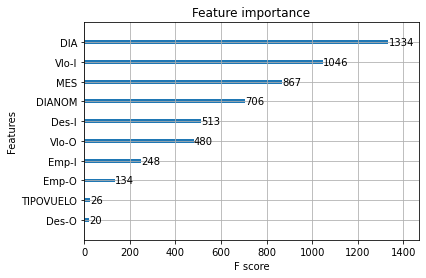

In [57]:
from xgboost import plot_importance
plot_importance(model_xgb);


# 5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

-> Tiene un buen performance ACCURACY > 0.97. 

-> Metricas = accuracy score. Lo use a modo de prueba para no complicarme con mas metricas.

-> Algoritmos =  lightGBM y XGBoost. Lo use porque son los mas optimos aunque no son algoritmos no parametricas, lo uso usualmente para tener un prediccion precisa.

-> Las variables que mas influyen son: DIA, MES, Vlo-I, DIANOM.

-> Agregar mas variables (internas o externas), establecer el tiempo para definir cuando es retraso (conocimiento de negocio), hacer feature engineering.